In [5]:
#
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')
from itertools import permutations,combinations
from IPython.display import clear_output
import seaborn as sns
from mne.event import define_target_events
from scipy import signal

data_path = os.path.dirname(os.path.dirname(os.getcwd()))

save_path = data_path + '/python/data/coherence'
info = mne.io.read_raw_fif((save_path+'-info'),preload=True)

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']

#subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia','Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Silvia','Silvia2','Tommaso']
subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia','Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara','Silvia','Silvia2','Tommaso']



remove_first = 0.5 #seconds


Opening raw data file D:\projects\current\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


In [6]:
Tmin = 0
Tmax = 3.51
trial_len = 2

In [ ]:
# extract trials of tmax second and remove the wrong answer trials and seperate them in three conditions

for s in subject_name:
    raw_fname = data_path + '/python/data/rawEEG/'+s+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)
    raw_fname = data_path + '/behaviour/data/subject/'+s+'_behaviour_normalized.mat'
    mat = scipy.io.loadmat(raw_fname)
    epochs = listen_italian_functions.epoch(raw, mat,Tmin, Tmax)
    save_path = data_path + '/python/data/coherence_epochs/'+s+'-coh-epo-'+str(Tmin) \
                            +'-'+str(Tmax)+'-trialLen-'+str(trial_len)+'_normalized.fif'
    epochs.save(save_path)
    print('----------------------------------------------------------------------------------------------------------------'+s)
    clear_output()

# Read the epoches

In [7]:
# read from epoches single cut


GA_epoches = []
for s in subject_name:
    save_path = data_path + '/python/data/coherence_epochs/'+s+'-coh-epo-'+str(Tmin)+'-' \
    +str(Tmax)+'-trialLen-'+str(trial_len)+'_normalized.fif'
    epochs = mne.read_epochs(save_path)
    GA_epoches.append(epochs)
    print('----------------------------------------------------------------------------------------------------------------'+s)
clear_output()

In [4]:
# additional eeg segments
Tmin = 0
Tmax = 3.51
trial_len = 2

GA_epoches = []
for s in subject_name:
    save_path = data_path + '/python/data/coherence_epochs/'+s+'-coh-epo-'+str(Tmin)+'-' \
    +str(Tmax)+'-trialLen-'+str(trial_len)+'_normalized.fif'
    a = mne.read_epochs(save_path)
    
    if(s!='Jonluca'):
        save_path = data_path + '/python/data/coherence_epochs/'+s+'-coh-epo-'+str(Tmin)+'-' \
        +str(7.02)+'-trialLen-'+str(trial_len)+'_normalized.fif'
        bb = mne.read_epochs(save_path)

        b = bb.copy().crop(Tmax,7.02)
        b.times = a.times
        epochs = mne.epochs.concatenate_epochs([a,b])
    else:
        epochs = a


    GA_epoches.append(epochs)
    print('----------------------------------------------------------------------------------------------------------------'+s)
clear_output()

Reading D:\projects\current\listen_italian_motor_entrainment\analysis/python/data/coherence_epochs/Alice-coh-epo-0-3.51-trialLen-2_normalized.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    3507.50 ms
        0 CTF compensation matrices available
124 matching events found
No baseline correction applied
124 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading D:\projects\current\listen_italian_motor_entrainment\analysis/python/data/coherence_epochs/Alice-coh-epo-0-7.02-trialLen-2_normalized.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    7017.50 ms
        0 CTF compensation matrices available
20 matching events found
No baseline correction applied
20 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


AttributeError: can't set attribute

In [8]:
# outlier detection EEG make them zero

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [5, 95])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound)),lower_bound,upper_bound

def outliers_z_score(ys):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

def outliers_modified_z_score(ys):
    threshold = 5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)


eeg_channles = GA_epoches[0].ch_names[0:59]

for s in range(0,len(subject_name)):
    E = GA_epoches[s].copy()
    e = GA_epoches[s].copy().pick_channels(eeg_channles).get_data()
    A = []
    for ch in range(59):
        a = e[:,ch,:]
        aa = a.flatten()
        b=outliers_iqr(aa)
        aa[b[0]]=float('nan')
        b = np.reshape(aa, a.shape)
        A.append(b)

    A = np.asarray(A)    
    A = np.swapaxes(A,1,0)

    e = GA_epoches[s].copy().get_data()
    e[:,0:59,:] = A
    a = np.argwhere(np.isnan(e))
    a = np.unique(a[:,0])
    e = np.delete(e, a, 0)
    
    events = E.events
    events = np.delete(events, a, 0)
    
    GA_epoches[s] = mne.EpochsArray(e, E.info, events, 0, E.event_id)
    
clear_output()

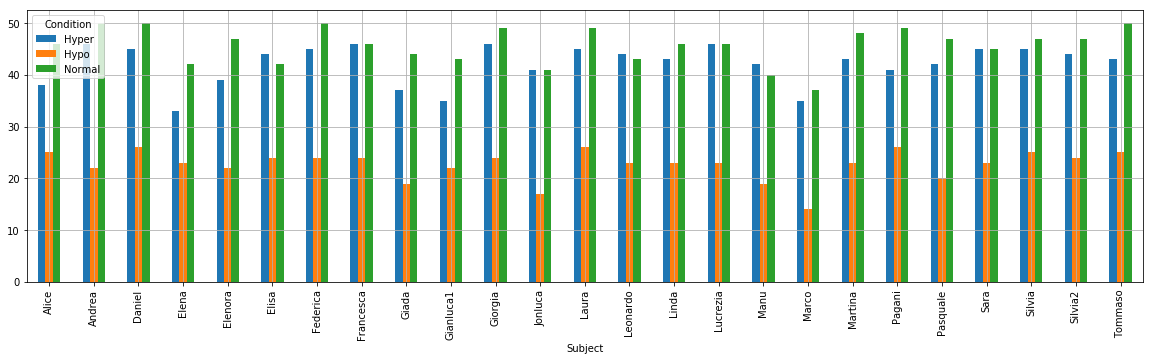

In [9]:
#
condition = ['Hyper','Normal','Hypo']
frames = []
for s in range(0,len(subject_name)):
    df = pd.DataFrame({'Condition':'Hyper','Subject':subject_name[s],'noTrials':GA_epoches[s]['hyper'].get_data().shape[0]},index=[s])
    df = df.append(pd.DataFrame({'Condition':'Normal','Subject':subject_name[s],'noTrials':GA_epoches[s]['normal'].get_data().shape[0]},index=[s]))
    df = df.append(pd.DataFrame({'Condition':'Hypo','Subject':subject_name[s],'noTrials':GA_epoches[s]['hypo'].get_data().shape[0]},index=[s]))
    frames.append(df)
    
data=pd.concat((frames),axis=0)
a=data.groupby(['Subject','Condition']).sum()['noTrials'].unstack().plot(kind='bar',figsize=(20,5),grid=True)

In [15]:
delay = np.arange(-5,5.25,0.25) / 10
delay

array([-0.5  , -0.475, -0.45 , -0.425, -0.4  , -0.375, -0.35 , -0.325,
       -0.3  , -0.275, -0.25 , -0.225, -0.2  , -0.175, -0.15 , -0.125,
       -0.1  , -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,
        0.1  ,  0.125,  0.15 ,  0.175,  0.2  ,  0.225,  0.25 ,  0.275,
        0.3  ,  0.325,  0.35 ,  0.375,  0.4  ,  0.425,  0.45 ,  0.475,
        0.5  ])

In [16]:
# matlab filedtrip
save_path = data_path + '/python/data/coherence'

info = mne.io.read_raw_fif((save_path+'-info'),preload=True)

features = ['envelop','lipaparature']
eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']

con = 'All'


# save clusterpermitation  matlab files for matlab analysis
for s in range(0,len(subject_name)):
    save_path = data_path + '/python/data/coherence_analysis_matlab/'+subject_name[s]+'.mat'
    for d in delay:        
        c = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,
                                       features,eeg_channles,con)

        #a=GA_epoches[s].get_data()
        #aa = np.hstack((np.arange(0,60),61))
        #a=a[:,aa,:]
        #t=GA_epoches[s].times
        t = np.arange(0,c.shape[2])
        save_path = data_path + '/python/data/coherence_analysis_matlab/'+subject_name[s]+\
                    '-trialLength'+str(trial_len)+'-delay'+str(d)+'.mat'

        scipy.io.savemat(save_path, {'data':c,'label':np.stack(info.ch_names),'time':t})
clear_output()

# Measuring the coherence

In [12]:
# coherence functions
def coherence_preprocess_delay(epochs,remove_first,d,trial_len,extra_channels,eeg_channles,condition):	

    if condition != 'All':
        E = epochs[condition].copy()
    else:
        E = epochs.copy()
        
    eeg = E.copy().pick_channels(eeg_channles)
    speech = E.copy().pick_channels(extra_channels)

    E = eeg.copy().crop(d+remove_first,d+remove_first+trial_len)
    S = speech.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    
    #E = eeg.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    #S = speech.copy().crop(d+remove_first,d+remove_first+trial_len)
    
    c = np.concatenate((E.get_data(),S.get_data()),axis=1)
    
    return c


def get_coherence(epochs,sfreq,fmin,fmax,indices,mode,method,time_bandwidth):
     # Define wavelet frequencies and number of cycles
    con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(epochs, method=method,mode=mode, 
                                                                                   sfreq=sfreq, fmin = fmin,fmax=fmax,
                                                                                   indices=indices, 
                                                                                   mt_bandwidth =time_bandwidth,
                                                                                   verbose='ERROR')

    return con,freqs,n_tapers

In [25]:
fmin = 0.25
fmax = 15
mode = 'multitaper'
method = 'coh'
time_bandwidth = 2.4

In [26]:
# seperate frequecny


features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']

condition = ['hyper','normal','hypo','All']
condition = ['All']

delay = np.arange(-5,5.5,0.5) / 10

indices = (np.repeat([np.arange(59,len(features)+59)],59),np.tile(np.arange(0,59),len(features))) 

frames = []
for s in range(0,len(subject_name)):
    for d in delay:        
        for con in condition:
            c = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,features,eeg_channles,con)
            coh,freqs,n_tapers = get_coherence(c,sfreq,fmin,fmax,indices,mode,method,time_bandwidth)

            freqs = np.round(freqs,decimals=1)
            for fr in range(0,len(freqs)):
                a = freqs[fr]
                cc = np.split(coh[:,fr], len(features))
                for f in range(0,len(features)):
                    feature = features[f]                    
                    if con != 'All':
                        df = pd.DataFrame({'Condition':con,'Freq':a,'Delay':d,'Subject':subject_name[s],'Feature':feature,
                                       'Data':[cc[f].flatten()],'noTrials':GA_epoches[s][con].get_data().shape[0],})
                    else:
                        df = pd.DataFrame({'Condition':con,'Freq':a,'Delay':d,'Subject':subject_name[s],'Feature':feature,
                                       'Data':[cc[f].flatten()],'noTrials':GA_epoches[s].get_data().shape[0],})
                    frames.append(df) 
                
        print(str(d)+'-'+subject_name[s])
    clear_output()       
        
data=pd.concat((frames),axis=0)
save_path = data_path + '/python/data/coherence/coh-multitaper3cycle-1-40.5Hz-0.5step_additinalSegments.pkl'
save_path = data_path + '/python/data/coherence/coh-fourier-1-40.5Hz-0.5step_additinalSegments.pkl'
save_path = data_path + '/python/data/coherence/bandwidth_2_1-15hz.pkl'

save_path = data_path + '/python/data/coherence/'+method \
            +'-'+mode+'_timeBandwidth_'+str(time_bandwidth)+\
            '_3cycle-1-40.5Hz-0.5step_trialLength'+str(trial_len)+'.pkl'


data.to_pickle(save_path)


In [ ]:
# average frequency
def coherence_preprocess_delay(epochs,remove_first,d,trial_len,extra_channels,eeg_channles,condition):	

    if condition != 'All':
        E = epochs[condition].copy()
    else:
        E = epochs.copy()
        
    eeg = E.copy().pick_channels(eeg_channles)
    speech = E.copy().pick_channels(extra_channels)

    E = eeg.copy().crop(d+remove_first,d+remove_first+trial_len)
    S = speech.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    
    #E = eeg.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    #S = speech.copy().crop(d+remove_first,d+remove_first+trial_len)
    
    c = np.concatenate((E.get_data(),S.get_data()),axis=1)
    
    return c


def get_coherence(epochs,sfreq,fmin,fmax,indices):
     # Define wavelet frequencies and number of cycles
    con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(epochs, method='coh',mode='multitaper', 
                                                                                   sfreq=sfreq, fmin = fmin,fmax=fmax,
                                                                                   indices=indices, tmin=0, 
                                                                                   mt_adaptive=True,faverage=True,
                                                                                   block_size=1000,verbose='ERROR',
                                                                                   mt_bandwidth = 1.5 )

    return con,freqs,n_tapers



freq_band = [(1,4),(4,8),(8,12)]
freq_band_txt = [2.5,6,10]


features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']

condition = ['hyper','normal','hypo','All']
con = 'All'

delay = np.arange(-5,5.5,0.5) / 10


indices = (np.repeat([np.arange(59,len(features)+59)],59),np.tile(np.arange(0,59),len(features))) 

frames = []
for s in range(0,len(subject_name)):
    for d in delay:        
        for fr in range(0,len(freq_band)):
            c = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,features,eeg_channles,con)
            fmin = freq_band[fr][0]
            fmax = freq_band[fr][1]
            coh,freqs,n_tapers = get_coherence(c,sfreq,fmin,fmax,indices)

            a = freq_band_txt[fr]
            cc = np.split(coh, len(features))
            for f in range(0,len(features)):
                feature = features[f]                    
                if con != 'All':
                    df = pd.DataFrame({'Condition':con,'Freq':a,'Delay':d,'Subject':subject_name[s],'Feature':feature,
                                   'Data':[cc[f].flatten()],'noTrials':GA_epoches[s][con].get_data().shape[0],})
                else:
                    df = pd.DataFrame({'Condition':con,'Freq':a,'Delay':d,'Subject':subject_name[s],'Feature':feature,
                                   'Data':[cc[f].flatten()],'noTrials':GA_epoches[s].get_data().shape[0],})
                frames.append(df) 
                
        print(str(d)+'-'+subject_name[s])
        #clear_output()       
        
data=pd.concat((frames),axis=0)
save_path = data_path + '/python/data/coherence/coh-multitaper_1.5hz-threeBands_averageFreq.pkl'
data.to_pickle(save_path)
clear_output()

In [12]:
6/2.5

2.4

In [ ]:
# whole trial

def epoch(raw, mat,Tmin, Tmax):
    # ignore stimuli shorter than tmax ms
    events = mne.find_events(raw, stim_channel='Trigger')
    reference_id = 105  # speech onset
    target_id = 106  # speech offset
    sfreq = raw.info['sfreq']  # sampling rate
    tmin = 0  
    new_id = 99  # the new event id for a hit. If None, reference_id is used.
    fill_na = 105  # the fill value for misses
    events_, lag = define_target_events(events, reference_id, target_id,sfreq, tmin, Tmax, new_id, fill_na)
    events_  = np.where(events_[:,2] == 105)[0] +1


    #behaviour (remove the wrong answer trials and seperate the in three conditions)	
    condition= mat['behaviour']['condition'][0]
    response= mat['behaviour']['response'][0]
    a = np.hstack((condition[0],response[0]))

    df = pd.DataFrame({'condition':a[:,0],'response':a[:,1]})
    df.index = df.index + 1

    hyper  = df.loc[(df['condition'] == 1) & (df['response'] == 0)]
    normal = df.loc[(df['condition'] == 2) & (df['response'] == 0)]
    hypo   = df.loc[(df['condition'] == 3) & (df['response'] == 0)]

    events = mne.find_events(raw, stim_channel='trial_no')
    hyper = np.intersect1d(events_, hyper.index.values)
    normal = np.intersect1d(events_, normal.index.values)
    hypo = np.intersect1d(events_, hypo.index.values)

    a = np.concatenate((hyper,normal,hypo),axis=0)
    IDX = np.sort(a, axis=0) -1

    hyper = events[hyper-1]
    hyper[:,2] = 1
    normal = events[normal-1]
    normal[:,2] = 2
    hypo = events[hypo-1]
    hypo[:,2] = 3
    a = np.vstack((hyper,normal,hypo))
    events = np.sort(a, axis=0)
    
    ##########
    
    #add EMA, envelop signal as extra channels
    extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
    envelop = mat['behaviour']['envelop'][0][0]
    jawaopening = mat['behaviour']['jawaopening'][0][0]
    lipaparature = mat['behaviour']['lipaparature'][0][0]
    lipProtrusion = mat['behaviour']['lipProtrusion'][0][0]
    TTCD = mat['behaviour']['TTCD'][0][0]
    TMCD = mat['behaviour']['TMCD'][0][0]
    TBCD = mat['behaviour']['TBCD'][0][0]
    A = []
    for i in range(0,len(IDX)):
        a = np.vstack((envelop[IDX[i]][0],jawaopening[IDX[i]][0].T,lipaparature[IDX[i]][0].T,lipProtrusion[IDX[i]][0].T,
                       TTCD[IDX[i]][0].T,TMCD[IDX[i]][0].T,TBCD[IDX[i]][0].T))
        A.append(a)
    
    return events,A

def restructure_data(raw,events,EMA):
    
    events_ = mne.find_events(raw, stim_channel='Trigger')
    a = events_[np.where(events_[:,2] == 105)[0],0]
    b = events_[np.where(events_[:,2] == 106)[0],0]

    c = np.in1d(a,events[:,0])
    a = a[c] - raw.first_samp
    b = b[c] - raw.first_samp

    A = raw.get_data()
    B=[]
    for i in range(0,len(a)):
        c = signal.decimate(A[0:59,a[i]:b[i]], 5) # decimate to 200 hz 1000/200 =5
        d = signal.decimate(EMA[i], 2) # decimate to 200 hz 400/200 = 5

        #c = A[0:59,a[i]:b[i]]
        #d = EMA[i]
        if(c.shape[1]>d.shape[1]):
            x = np.pad(d,((0,0),(0,c.shape[1]-d.shape[1])), 'constant')
            x = np.vstack((c,x))
        elif(c.shape[1]<d.shape[1]):
            x = np.pad(c,((0,0),(0,d.shape[1]-c.shape[1])), 'constant')
            x = np.vstack((x,d))
        else:
            x = np.vstack((c,d))
        B.append(x)
    clear_output()
    
    x = np.column_stack(B)
    eeg = x[0:59,:]
    ema = x[60:66,:]
    return B

def get_data(data,remove_first,d,sfreq):
    
    rs = 0.5*sfreq
    dd = d*sfreq
    L = []
    trial_no = len(data)
    X=[]
    for tr in range(0,trial_no):
        #print(data[tr].shape[1])

        aa = data[tr][:,int((remove_first)*sfreq):]
        
        
        trial_len = aa.shape[1] - 1*sfreq

        start_i = round(dd)
        end_i = round(dd+trial_len)

        
        start_s = round(rs)
        end_s = round(rs+trial_len)

        
            
        #print(int(start_i),int(end_i),int(start_s),int(end_s))
        
        E = aa[0:59,int(start_i):int(end_i)]
        S = aa[-7:,int(start_s):int(end_s)]
        
        
        a = np.vstack((E,S))
        X.append(a)
        L.append(int(trial_len))

    return X,np.max(np.asarray(L))

def pad_data(data,L):

    trial_no = len(data)
    X=[]
    for tr in range(0,trial_no):
        a = np.pad(data[tr],((0,0),(0,L-data[tr].shape[1])), 'constant')
        X.append(a)

    X = np.stack(X)
    return X

def get_coherence(epochs,sfreq,fmin,fmax,indices):
    con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(epochs, method='coh',mode='multitaper', 
                                                                                   sfreq=sfreq, fmin = fmin,fmax=fmax,
                                                                                   indices=indices, tmin=0, 
                                                                                   mt_adaptive=False,faverage=False,
                                                                                   block_size=1000,verbose='ERROR')

    return con,freqs,n_tapers

remove_first=0.5
sfreq = 200
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
indices = (np.repeat([np.arange(59,len(features)+59)],59),np.tile(np.arange(0,59),len(features))) 
con = 'All'
fmin = 1
fmax = 40

delay = np.arange(-5,5.5,0.5) / 10

frames = []
for s in range(0,len(subject_name)):
    raw_fname = data_path + '/python/data/rawEEG/'+subject_name[s]+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)
    raw_fname = data_path + '/behaviour/data/subject/'+subject_name[s]+'_behaviour_normalized.mat'
    mat = scipy.io.loadmat(raw_fname)

    events,EMA = epoch(raw, mat,0, 1)
    A_sub = restructure_data(raw,events,EMA)
    
    for d in delay:
        A,a = get_data(A_sub,remove_first,d+0.5,sfreq)
        A = pad_data(A,a)
        coh,freqs,n_tapers = get_coherence(A,sfreq,fmin,fmax,indices)
        freqs = np.round(freqs,decimals=1)
        for fr in range(0,len(freqs)):
            a = freqs[fr]
            cc = np.split(coh[:,fr], len(features))
            for f in range(0,len(features)):
                feature = features[f]                    

                df = pd.DataFrame({'Condition':con,'Freq':a,'Delay':d,'Subject':subject_name[s],'Feature':feature,
                               'Data':[cc[f].flatten()]})
                frames.append(df) 
        print(str(d)+'-'+subject_name[s])

        
        
data=pd.concat((frames),axis=0)
save_path = data_path + '/python/data/coherence/coherence_multitaper_wholeTrial_withdelay.pkl'

data.to_pickle(save_path)        

-0.5-Tommaso
-0.45-Tommaso
-0.4-Tommaso
-0.35-Tommaso
-0.3-Tommaso
-0.25-Tommaso
-0.2-Tommaso
-0.15-Tommaso
-0.1-Tommaso
-0.05-Tommaso
0.0-Tommaso
0.05-Tommaso
0.1-Tommaso
0.15-Tommaso
0.2-Tommaso
0.25-Tommaso
0.3-Tommaso
0.35-Tommaso
0.4-Tommaso


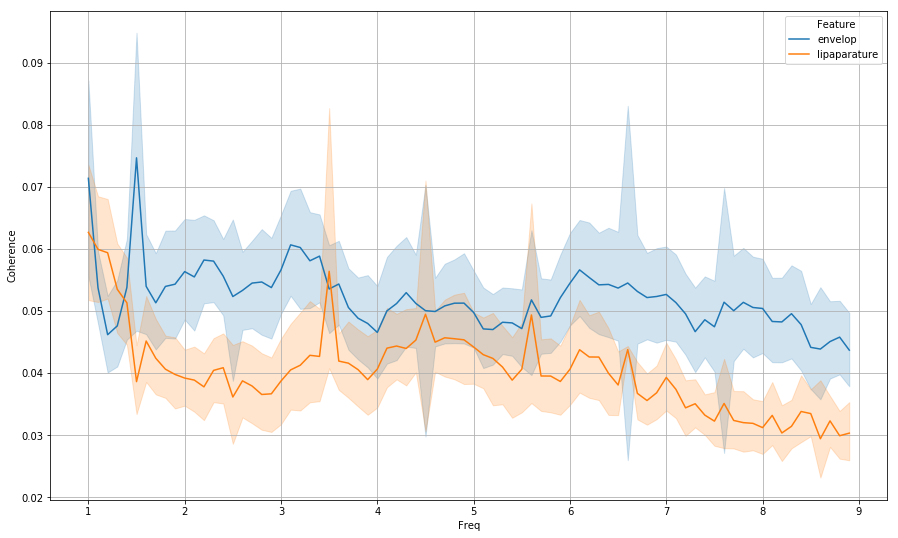

In [92]:
#
save_path = data_path + '/python/data/coherence/test.pkl'
dataM=pd.read_pickle(save_path)
a  = dataM['Data'].apply(lambda x: np.mean(x))
dataM['Coherence'] = pd.Series(a, index=dataM.index)

freq = np.unique(dataM['Freq'])[0:80]
#freq = np.arange(1,20.5)

features = ['envelop','lipaparature']

#M = dataM[(dataM['Condition']=='All') & (dataM['Delay']==0) & (dataM['Feature'].isin(features)) & (dataM['Freq'].isin(freq))]
M = dataM[(dataM['Delay']==0) & (dataM['Feature'].isin(features)) & (dataM['Freq'].isin(freq))]

f, ax = plt.subplots(figsize=(15,9))
sns.lineplot(data=M,x='Freq',y='Coherence',hue='Feature')
ax.grid(True)

In [89]:
freq=2.5
vmin=-0.04

In [90]:
#
S = dataM[(dataM['Condition']=='All') & (dataM['Delay']==0) 
          & (dataM['Feature']=='envelop') & (dataM['Freq']==freq)]['Data'].get_values()
S = np.stack(S).mean(axis=0)

L = dataM[(dataM['Condition']=='All') & (dataM['Delay']==0) 
          & (dataM['Feature']=='lipaparature') & (dataM['Freq']==freq)]['Data'].get_values()
L = np.stack(L).mean(axis=0)

vmax=-vmin

f, ax = plt.subplots(figsize=(15,5))
a=plt.subplot(1, 3, 1)
mne.viz.plot_topomap(S, info.info,cmap='RdBu_r',vmin=vmin,vmax=vmax,axes=a,show=False)
b=plt.subplot(1, 3, 2)
mne.viz.plot_topomap(L, info.info,cmap='RdBu_r',vmin=vmin,vmax=vmax,axes=b,show=False)
c=plt.subplot(1, 3, 3)
mne.viz.plot_topomap(S-L, info.info,cmap='RdBu_r',vmin=vmin,vmax=vmax,axes=c,show=False)

KeyError: 'Condition'

In [49]:
#

features = ['envelop','lipaparature']



def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    if 'mask' in data:
        mask = data['mask'].any()
        mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)
    else:
        mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax)


def plot_topo_image(df,vmin,vmax,typeF,cmap):
    fg = sns.FacetGrid(df,col=typeF,margin_titles=True)
    b = fg.map_dataframe(draw_heatmap, 'Data')
    b = b.set_xlabels('')
    b.fig.subplots_adjust(top=0.7)
    b.fig.subplots_adjust(right=0.8)
    cbar_ax = b.fig.add_axes([0.82,0.25,0.01,0.45]) # [left, bottom, width, height] 
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Coherence')

df1,A1 = get_subject_avg_inDelay(dataM,delay,features[0],freq,condition,subject_name)
vmin = np.round(min(A1),decimals=2)
vmax = np.round(max(A1),decimals=2)
plot_topo_image(df1,vmin,vmax,'Delay','Reds')

df2,A2 = get_subject_avg_inDelay(dataM,delay,features[1],freq,condition,subject_name)
vmin = np.round(min(A2),decimals=2)
vmax = np.round(max(A2),decimals=2)
plot_topo_image(df2,vmin,vmax,'Delay','Reds')

df = df1
df['Data'] = df1['Data']-df2['Data']
A = np.asarray(A1) - np.asarray(A2)
vmin = np.round(min(A),decimals=5)
vmax = np.round(max(A),decimals=5)
vmin=-0.01
vamx=0.01
plot_topo_image(df,vmin,vmax,'Delay','Reds')


KeyError: 'the label [envelop] is not in the [index]'

In [1]:
# whole trial functions
def epoch(raw, mat,Tmin, Tmax):
    # ignore stimuli shorter than tmax ms
    events = mne.find_events(raw, stim_channel='Trigger')
    reference_id = 105  # speech onset
    target_id = 106  # speech offset
    sfreq = raw.info['sfreq']  # sampling rate
    tmin = 0  
    new_id = 99  # the new event id for a hit. If None, reference_id is used.
    fill_na = 105  # the fill value for misses
    events_, lag = define_target_events(events, reference_id, target_id,sfreq, tmin, Tmax, new_id, fill_na)
    events_  = np.where(events_[:,2] == 105)[0] +1


    #behaviour (remove the wrong answer trials and seperate the in three conditions)	
    condition= mat['behaviour']['condition'][0]
    response= mat['behaviour']['response'][0]
    a = np.hstack((condition[0],response[0]))

    df = pd.DataFrame({'condition':a[:,0],'response':a[:,1]})
    df.index = df.index + 1

    hyper  = df.loc[(df['condition'] == 1) & (df['response'] == 0)]
    normal = df.loc[(df['condition'] == 2) & (df['response'] == 0)]
    hypo   = df.loc[(df['condition'] == 3) & (df['response'] == 0)]

    events = mne.find_events(raw, stim_channel='trial_no')
    hyper = np.intersect1d(events_, hyper.index.values)
    normal = np.intersect1d(events_, normal.index.values)
    hypo = np.intersect1d(events_, hypo.index.values)

    a = np.concatenate((hyper,normal,hypo),axis=0)
    IDX = np.sort(a, axis=0) -1

    hyper = events[hyper-1]
    hyper[:,2] = 1
    normal = events[normal-1]
    normal[:,2] = 2
    hypo = events[hypo-1]
    hypo[:,2] = 3
    a = np.vstack((hyper,normal,hypo))
    events = np.sort(a, axis=0)
    
    ##########
    
    #add EMA, envelop signal as extra channels
    extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
    envelop = mat['behaviour']['envelop'][0][0]
    jawaopening = mat['behaviour']['jawaopening'][0][0]
    lipaparature = mat['behaviour']['lipaparature'][0][0]
    lipProtrusion = mat['behaviour']['lipProtrusion'][0][0]
    TTCD = mat['behaviour']['TTCD'][0][0]
    TMCD = mat['behaviour']['TMCD'][0][0]
    TBCD = mat['behaviour']['TBCD'][0][0]
    phonemeRate = mat['behaviour']['phonemeRate'][0][0]
    phonemeDuration = mat['behaviour']['phonemeDuration'][0][0]

    A = []
    B = []
    for i in range(0,len(IDX)):
        a = np.vstack((envelop[IDX[i]][0],jawaopening[IDX[i]][0].T,lipaparature[IDX[i]][0].T,lipProtrusion[IDX[i]][0].T,
                       TTCD[IDX[i]][0].T,TMCD[IDX[i]][0].T,TBCD[IDX[i]][0].T))
        A.append(a)
        a = np.hstack((phonemeRate[IDX[i]][0][0][0],phonemeDuration[IDX[i]][0][0][0]))
        B.append(a)
        
    return events,A,np.stack(B)

def restructure_data(raw,events,EMA):
    events_ = mne.find_events(raw, stim_channel='Trigger')
    a = events_[np.where(events_[:,2] == 105)[0],0]
    b = events_[np.where(events_[:,2] == 106)[0],0]

    c = np.in1d(a,events[:,0])
    a = a[c] - raw.first_samp
    b = b[c] - raw.first_samp

    A = raw.get_data()
    B=[]
    for i in range(0,len(a)):
        #c = signal.decimate(A[0:59,a[i]:b[i]], 10) # decimate to 200 hz 1000/100 =10
        #d = signal.decimate(EMA[i], 4) # decimate to 200 hz 400/100 = 4
        
        c = A[0:59,a[i]:b[i]] 
        d = EMA[i]

        #c = A[0:59,a[i]:b[i]]
        #d = EMA[i]
        if(c.shape[1]>d.shape[1]):
            x = np.pad(d,((0,0),(0,c.shape[1]-d.shape[1])), 'constant')
            x = np.vstack((c,x))
        elif(c.shape[1]<d.shape[1]):
            x = np.pad(c,((0,0),(0,d.shape[1]-c.shape[1])), 'constant')
            x = np.vstack((x,d))
        else:
            x = np.vstack((c,d))
        B.append(x)
    clear_output()
    
    x = np.column_stack(B)
    eeg = x[0:59,:]
    ema = x[60:66,:]
    return B

def restructure_data2(eeg,ema,temporal_aperature,L,features):
    
    aa = np.hstack(ema)
    aa = stats.zscore(aa, axis=1)
    if(features=='envelop'):
        aa = aa[0,:]
    else:
        aa = aa[1:,:]
    mark_bad_trial = []
    X = []
    
    for t in range(0,len(ema)):
        a = aa[:,0:L[t]]
        #print(a.shape)
        tmp =[]
        for i in range(0,a.shape[0]):
            x = toeplitz(a[i,:])
            y= np.tril(np.ones((x.shape[0], x.shape[0]), dtype=int))
            x = x*y
            tmp.append(x[:,0:temporal_aperature])
        tmp = np.hstack(tmp)

        if(tmp.shape[1]==600):
            tmp = np.hstack((tmp,np.ones((tmp.shape[0],1))))
            X.append(tmp) 
        else:
            mark_bad_trial.append(t)

        aa = aa[:,a.shape[1]:]

    ema = np.vstack(X)
    
    mark_bad_trial = np.asarray(mark_bad_trial)
    eeg_ = []
    for e in range(0,len(eeg)):
        if not(np.isin(e,mark_bad_trial)):        
            eeg_.append(eeg[e])

    eeg = np.hstack(eeg_)
    
    return eeg,ema.T,X,eeg_,mark_bad_trial

def get_data(data,remove_first,d,sfreq,one_delay):
    
    rs = 0.5*sfreq
    dd = d*sfreq
    L = []
    trial_no = len(data)
    eeg=[]
    ema=[]
    for tr in range(0,trial_no):

        # remove first from the begining
        aa = data[tr][:,int((remove_first)*sfreq):]
        
        if(one_delay==0):
            trial_len = aa.shape[1] - 1*sfreq

            start_i = round(dd)
            end_i = round(dd+trial_len)
            start_s = round(rs)
            end_s = round(rs+trial_len)

            E = aa[0:59,int(start_i):int(end_i)]
            S = aa[-7:,int(start_s):int(end_s)]
        elif(one_delay==1):
            E = aa[0:59,:]
            S = aa[-7:,:]
        
        eeg.append(E)
        ema.append(S)
        L.append(S.shape[1])
        
    return eeg,ema,np.asarray(L)

def get_coherence(epochs,sfreq,fmin,fmax,indices):
     # Define wavelet frequencies and number of cycles
    con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(epochs, method='coh',mode='multitaper', 
                                                                                   sfreq=sfreq, fmin = fmin,fmax=fmax,
                                                                                   indices=indices, tmin=0, 
                                                                                   mt_adaptive=True,faverage=False,
                                                                                   block_size=1000,verbose='ERROR' )

    return con,freqs,n_tapers

In [1]:
# single trial coherence
fmin = 1
fmax = 15

FREQ = np.round(np.arange(1,15.1,0.1),1)

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

eeg_channles = info.ch_names[0:59]
sfreq = info.info['sfreq']

condition = ['hyper','normal','hypo','All']
con = 'All'

delay = np.arange(-5,5.5,0.5) / 10


indices = (np.repeat([np.arange(59,len(features)+59)],59),np.tile(np.arange(0,59),len(features))) 

frames = []
for s in range(0,len(subject_name)):
    raw_fname = data_path + '/python/data/rawEEG/'+subject_name[s]+'_raw.fif'
    raw = mne.io.read_raw_fif(raw_fname,preload=True)
    raw_fname = data_path + '/behaviour/data/subject/'+subject_name[s]+'_behaviour_normalized.mat'
    mat = scipy.io.loadmat(raw_fname)

    events,a,phoneme_rate_dur = epoch(raw, mat,0, 1)
    A_sub = restructure_data(raw,events,a)
    
    for d in delay:
        eeg,ema,L = get_data(A_sub,remove_first,d+0.5,sfreq,0)  
        coh = np.zeros((len(eeg),413,len(FREQ)))
        for ccc in range(0,len(eeg)):
            A = np.vstack((eeg[ccc],ema[ccc]))
            cc,freqs,n_tapers = get_coherence(np.expand_dims(A, axis=0),sfreq,fmin,fmax,indices)
            freqs = np.round(freqs,decimals=1)
            freqs = np.nonzero(np.in1d(FREQ,freqs))[0]
            coh[ccc,:,freqs] = cc.T

        coh = np.asarray(coh)
        for ccc in range(0,len(eeg)):
            for fr in range(0,len(FREQ)):
                a = FREQ[fr]
                cc = np.split(coh[ccc,:,fr], len(features))
                for f in range(0,len(features)):
                    feature = features[f]    
                    df = pd.DataFrame({'condition':events[ccc,2],'Freq':a,'Trial':ccc,'Delay':d,
                                        'phoneme_rate':phoneme_rate_dur[ccc,0],'phoneme_dur':phoneme_rate_dur[ccc,1],
                                       'Subject':subject_name[s],'Feature':feature,
                                       'Data':[cc[f]]})
                    frames.append(df) 
                
        print(str(d)+'-'+subject_name[s])
        #clear_output()       
        
data=pd.concat((frames),axis=0)
save_path = data_path + '/python/data/coherence/coh-multitaper3cycle-1-15.5Hz-0.5step-adaptiveFalse-trialwise_lipaparature_envelop.pkl'
data.to_pickle(save_path)

NameError: name 'np' is not defined

In [27]:
# single trial coherence
fmin = 1
fmax = 15.5


features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
features = ['envelop','lipaparature']

eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']

condition = ['hyper','normal','hypo','All']
condition = ['All']

delay = np.arange(-5,5.5,0.5) / 10


indices = (np.repeat([np.arange(59,len(features)+59)],59),np.tile(np.arange(0,59),len(features))) 

frames = []
for s in range(0,len(subject_name)):
    for d in delay:        
        for con in condition:
            c = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,features,eeg_channles,con)
            
            condIDX = GA_epoches[s].events[:,2]
            
            coh = []
            for ccc in range(0,c.shape[0]):
                cc,freqs,n_tapers = get_coherence(np.expand_dims(c[ccc,:,:], axis=0),sfreq,fmin,fmax,indices)
                coh.append(cc)
    
            coh = np.asarray(coh)

            freqs = np.round(freqs,decimals=1)
            for fr in range(0,len(freqs)):
                a = freqs[fr]
                cc = np.split(coh[:,:,fr], len(features), axis=1)
                for f in range(0,len(features)):
                    feature = features[f]                    
                    if con != 'All':
                        df = pd.DataFrame({'Condition':con,'Freq':a,'Delay':d,'Subject':subject_name[s],'Feature':feature,
                                       'Data':[cc[f]],'noTrials':GA_epoches[s][con].get_data().shape[0],
                                          'condIDX':[condIDX]})
                    else:
                        df = pd.DataFrame({'Condition':con,'Freq':a,'Delay':d,'Subject':subject_name[s],'Feature':feature,
                                       'Data':[cc[f]],'noTrials':GA_epoches[s].get_data().shape[0],
                                          'condIDX':[condIDX]})
                    frames.append(df) 
                
        print(str(d)+'-'+subject_name[s])
        #clear_output()       
        
data=pd.concat((frames),axis=0)
save_path = data_path + '/python/data/coherence/coh-multitaper3cycle-1-15.5Hz-0.5step-adaptiveFalse-trialwise_lipaparature_envelop.pkl'
data.to_pickle(save_path)

-0.5-Alice


KeyboardInterrupt: 

# Bootstrapping and creating a surrogate distribution for each subject. substract the average of the distribution from the original coherence value.

In [45]:
def Coherence_preprocess_delay_surrogate(epochs,remove_first,d,trial_len,eeg_channles,keep_feat,condition,iter_freqs):	

    fmin = 0.5
    fmax = 40
    ##############
    if condition != 'All':
        E = epochs[condition].copy()
    else:
        E = epochs.copy()
    
    eeg = E.copy().pick_channels(eeg_channles)
    speech = E.copy().pick_channels(keep_feat)

    E = eeg.copy().crop(d+remove_first,d+remove_first+trial_len)
    S = speech.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    
    #E = eeg.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    #S = speech.copy().crop(d+remove_first,d+remove_first+trial_len)
    
    
    sfreq = E.info['sfreq']
    
    E = E.get_data()
    S = S.get_data()

    label = np.concatenate((eeg.ch_names,speech.ch_names))
    
    ##################### all possible combination
    trial_length=S.shape[0]
    a = list(permutations(np.arange(0,trial_length), 2))
    a = np.asarray(a)
    X = np.arange(0,trial_length)

    no_surrogates = 500 #dummy value
    B=[]
    for j in range(no_surrogates):
        X = np.roll(X,1)
        while True:
            A,a = get_combinations(X,a)        
            if A.shape[0] == trial_length:
                B.append(A)
                break
            elif len(a)==0:
                break
            else:
                X = np.roll(X,1)
                print('.',end=' ')
    
    B = np.asarray(B)
    no_surrogates = len(B)
    
    
    indices = []
    b = (np.repeat(59,59),np.arange(0,59))
    indices.append(b)
    b = (np.repeat(60,59),np.arange(0,59))
    indices.append(b)

    indices = np.concatenate((indices),axis=1)
    indices = (indices[0],indices[1])
    #######################################  

    frames = np.zeros((len(eeg_channles)*len(keep_feat),len(iter_freqs),no_surrogates))
    for i in range(no_surrogates):
        print('--------------------'+str(i))
        EE = E.copy()
        SS = S.copy()
        c = np.concatenate((EE[B[i][:,0]],SS[B[i][:,1]]),axis=1)
        
        coh,freqs = get_coherence(c,sfreq,fmin,fmax,indices)

        frames[:,:,i] = coh
        clear_output()  
        
    freqs = np.round(freqs,decimals=1)

    return frames,no_surrogates,freqs

def get_combinations(X,a):
    aa = a
    A=[]
    EEG = []
    Speech = []
    for i in range(0,len(X)):
        b = np.where(a[:,0]==X[i])
        if not len(b[0]) == 0:
            for k in range(len(b[0])):
                if not a[b[0][k],1] in Speech:
                    A.append(a[b[0][k],:])
                    EEG.append(a[b[0][k],0])
                    Speech.append(a[b[0][k],1])
                    a = np.delete(a, b[0][k], 0)
                    break
    if len(A) == len(X):                    
        return np.asarray(A),a
    else:
        return np.asarray(A),aa	

def get_coherence(epochs,sfreq,fmin,fmax,indices):
    con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(epochs, method='coh',mode='multitaper', 
                                                                                   sfreq=sfreq, fmin = fmin,fmax=fmax,
                                                                                   indices=indices, tmin=0, 
                                                                                   mt_adaptive=False,faverage=False, 
                                                                                   block_size=1000,verbose='ERROR')

    return con,freqs

In [6]:
# 1 random trails shuffeling
def coherence_preprocess_delay(epochs,remove_first,d,trial_len,extra_channels,eeg_channles,condition):	

    if condition != 'All':
        E = epochs[condition].copy()
    else:
        E = epochs.copy()
        
    eeg = E.copy().pick_channels(eeg_channles)
    speech = E.copy().pick_channels(extra_channels)

    E = eeg.copy().crop(d+remove_first,d+remove_first+trial_len)
    S = speech.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    
    #E = eeg.copy().crop(0.5+remove_first,0.5+remove_first+trial_len)
    #S = speech.copy().crop(d+remove_first,d+remove_first+trial_len)
        
    return E.get_data(),S.get_data()

def get_coherence(epochs,sfreq,fmin,fmax,indices):
     # Define wavelet frequencies and number of cycles
    con, freqs, times, n_epochs, n_tapers = mne.connectivity.spectral_connectivity(epochs, method='coh',mode='multitaper', 
                                                                                   sfreq=sfreq, fmin = fmin,fmax=fmax,
                                                                                   indices=indices, tmin=0, 
                                                                                   mt_adaptive=True,faverage=False,
                                                                                   block_size=1000,verbose='ERROR')

    return con,freqs,n_tapers

fmin=0.5
fmax=40

remove_first=0.5
trial_len=2

features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
eeg_channles = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']

condition = ['hyper','normal','hypo','All']
condition = ['All']
indices = (np.repeat([np.arange(59,len(features)+59)],59),np.tile(np.arange(0,59),len(features))) 

delay = np.arange(-5,5.5,0.5) / 10


frames = []
for s in range(0,len(subject_name)):
    for d in delay:        
        for con in condition:
            eeg,speech = coherence_preprocess_delay(GA_epoches[s],remove_first,d+0.5,trial_len,features,eeg_channles,con)
            
            a = np.random.randint(speech.shape[0],size= speech.shape[0])
            speech = speech[a,:,:]
            c = np.concatenate((eeg,speech),axis=1)
            
            coh,freqs,n_tapers = get_coherence(c,sfreq,fmin,fmax,indices)

            freqs = np.round(freqs,decimals=1)
            for fr in range(0,len(freqs)):
                a = freqs[fr]
                cc = np.split(coh[:,fr], len(features))
                for f in range(0,len(features)):
                    feature = features[f]                    
                    if con != 'All':
                        df = pd.DataFrame({'Condition':con,'Freq':a,'Delay':d,'Subject':subject_name[s],'Feature':feature,
                                       'Data':[cc[f].flatten()],'noTrials':GA_epoches[s][con].get_data().shape[0],})
                    else:
                        df = pd.DataFrame({'Condition':con,'Freq':a,'Delay':d,'Subject':subject_name[s],'Feature':feature,
                                       'Data':[cc[f].flatten()],'noTrials':GA_epoches[s].get_data().shape[0],})
                    frames.append(df) 
                
        print(str(d)+'-'+subject_name[s])
        #clear_output()       
        
data=pd.concat((frames),axis=0)
save_path = data_path + '/python/data/SurrogateCoherence/coh-multitaper3cycle-1-40.5Hz-0.5step_additinalSegments_1shuffel.pkl'
data.to_pickle(save_path)

-0.5-Alice
-0.45-Alice
-0.4-Alice
-0.35-Alice
-0.3-Alice
-0.25-Alice
-0.2-Alice
-0.15-Alice
-0.1-Alice
-0.05-Alice
0.0-Alice
0.05-Alice
0.1-Alice
0.15-Alice
0.2-Alice
0.25-Alice
0.3-Alice
0.35-Alice
0.4-Alice
0.45-Alice
0.5-Alice
-0.5-Andrea
-0.45-Andrea
-0.4-Andrea
-0.35-Andrea
-0.3-Andrea
-0.25-Andrea
-0.2-Andrea
-0.15-Andrea
-0.1-Andrea
-0.05-Andrea
0.0-Andrea
0.05-Andrea
0.1-Andrea
0.15-Andrea
0.2-Andrea
0.25-Andrea
0.3-Andrea
0.35-Andrea
0.4-Andrea
0.45-Andrea
0.5-Andrea
-0.5-Daniel
-0.45-Daniel
-0.4-Daniel
-0.35-Daniel
-0.3-Daniel
-0.25-Daniel
-0.2-Daniel
-0.15-Daniel
-0.1-Daniel
-0.05-Daniel
0.0-Daniel
0.05-Daniel
0.1-Daniel
0.15-Daniel
0.2-Daniel
0.25-Daniel
0.3-Daniel
0.35-Daniel
0.4-Daniel
0.45-Daniel
0.5-Daniel
-0.5-Elena
-0.45-Elena
-0.4-Elena
-0.35-Elena
-0.3-Elena
-0.25-Elena
-0.2-Elena
-0.15-Elena
-0.1-Elena
-0.05-Elena
0.0-Elena
0.05-Elena
0.1-Elena
0.15-Elena
0.2-Elena
0.25-Elena
0.3-Elena
0.35-Elena
0.4-Elena
0.45-Elena
0.5-Elena
-0.5-Elenora
-0.45-Elenora
-0.4-Elenor

In [ ]:
iter_freqs = np.arange(0.5,40,0.5)


eeg_chan = GA_epoches[0].ch_names[0:59]
sfreq = GA_epoches[0].info['sfreq']

delay = np.arange(-5,5.5,0.5) / 10

condition = ['All']
#condition = ['hyper','normal','hypo','All']

features = ['envelop','lipaparature']

for s in range(0,len(subject_name)):
    frame = [] 
    for d in range(0,len(delay)):        
        for con in condition:
            surrogate_coh,no_surrogates,freqs = Coherence_preprocess_delay_surrogate(GA_epoches[s],remove_first,
                                                                        delay[d] + 0.5,trial_len,eeg_chan,features,
                                                                        con,iter_freqs)

            # mean or median of the surrogate distribution
            coh=surrogate_coh
            coh = np.round(coh,decimals=6)

            for fr in range(0,len(freqs)):
                a = freqs[fr]

                cc = np.split(coh[:,fr,:], len(features))
                for f in range(0,len(features)):
                    feature = features[f]
                    df = pd.DataFrame({'Condition':con,'Freq':a,'Delay':delay[d],'Subject':subject_name[s],'Feature':feature,
                                   'Data':[cc[f]],'no_surrogates':no_surrogates})
                    frame.append(df) 
                
            print(str(delay[d])+'-'+subject_name[s])
            
    data=pd.concat((frame),axis=0)
    a = ('-').join(features)
    save_path = data_path + '/python/data/SurrogateCoherence/SurrogateCoherence-removedFirst-' \
    +str(remove_first)+'-'+a+'-'+subject_name[s]+'-multitaper3cycle-1-40.5Hz-0.5step-adaptiveTrue_additinalSegments_t.pkl'
    data.to_pickle(save_path)  

# putit into one file    
A=[]
a = ('-').join(features)
for s in subject_name:
    save_path = data_path + '/python/data/SurrogateCoherence/SurrogateCoherence-removedFirst-' \
    +str(remove_first)+'-'+a+'-'+s+'-multitaper3cycle-1-40.5Hz-0.5step-adaptiveTrue_additinalSegments_t.pkl'
    A.append(pd.read_pickle(save_path))

data = pd.concat((A),axis=0)
save_path = data_path + '/python/data/SurrogateCoherence/SurrogateCoherence-removedFirst-' \
    +str(remove_first)+'-'+a+'-multitaper3cycle-1-40.5Hz-0.5step-adaptiveTrue_additinalSegments_t.pkl'  
data.to_pickle(save_path)  


--------------------16
